In [1]:
import numpy as np
import tensorflow as tf

In [5]:
import sys
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../influential_points")

from experiments import ExperimentRunner

## Set-up Data

In [6]:
mnist_dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

binary_train_images = train_images[(train_labels == 1) | (train_labels == 7)]
binary_train_labels = train_labels[(train_labels == 1) | (train_labels == 7)]
binary_test_images = test_images[(test_labels == 1) | (test_labels == 7)]
binary_test_labels = test_labels[(test_labels == 1) | (test_labels == 7)]

train_x = binary_train_images / 255.0
test_x = binary_test_images / 255.0

train_y = (binary_train_labels == 1).astype(np.float64).reshape((-1, 1))
test_y = (binary_test_labels == 1).astype(np.float64).reshape((-1, 1))

num_train_points = len(train_x)
num_test_points = len(test_x)

In [7]:
scores = np.load("../output/lr_on_binary_mnist_scores.npz")

inf = scores["influence"]
rif = scores["theta_relatif"]

gc = scores["grad_cos"]

# Representer values for 7's need to be flipped (positive values => contibutes to predicting 1's).
rp = scores["representer_values"] * (test_y.T * 2.0 - 1.0)

# All data Shapley values are flipped (negative values => smaller loss => positive example).
ds = - np.load("../output/lr_on_binary_mnist_shapley_loss.npz")["shapley_values"]

In [8]:
# Read-able labels to display.
classes = [1, 7]

train_true = binary_train_labels
test_true = binary_test_labels

preds = np.load("../output/lr_on_binary_mnist_preds.npz")
train_preds = np.array([7, 1])[(preds["train_preds"].T[0] > 0).astype(np.int)]
test_preds = np.array([7, 1])[(preds["test_preds"].T[0] > 0).astype(np.int)]

In [9]:
# Potential points of interest.
print("1s:", np.arange(num_test_points)[test_true == 1][:10])
print("7s:", np.arange(num_test_points)[test_true == 7][:10])
print("Misclassified:", np.arange(num_test_points)[test_true != test_preds][:10])

1s: [ 1  2  3  6  7 10 11 12 14 15]
7s: [ 0  4  5  8  9 13 16 17 18 20]
Misclassified: [124 144 273 278 286 289 296 329 372 379]


In [10]:
e = ExperimentRunner(
    inf,
    rif,
    gc,
    rp,
    ds,
    train_x,
    train_y,
    test_x,
    test_y,
    num_train_points,
    num_test_points,
    classes,
    train_true,
    test_true,
    train_preds,
    test_preds
)

## Visualising Examples

### Global Examples

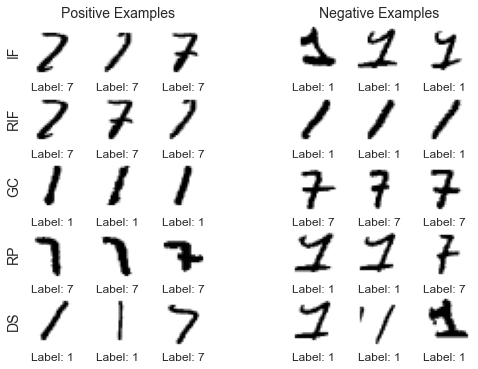

In [11]:
e.disp_global()

### Local Examples

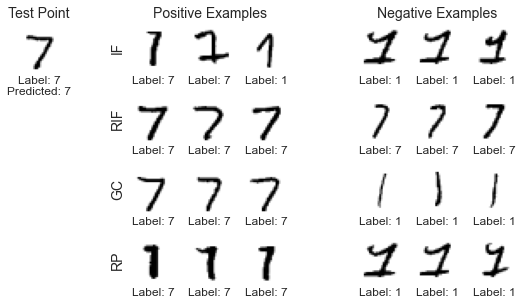

In [10]:
# Example of a 7.
e.disp_local(test_idx=0)

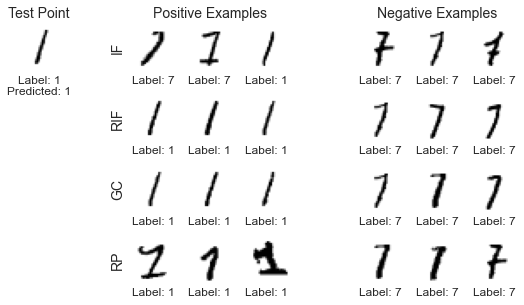

In [11]:
# Example of a 1.
e.disp_local(test_idx=1)

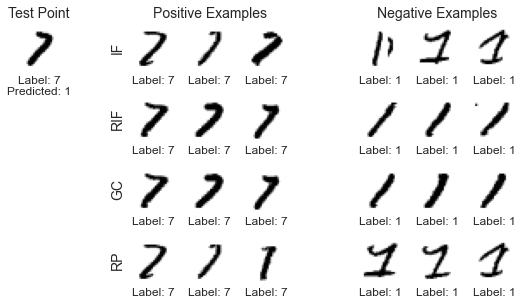

In [12]:
# Example of a mis-classification.
e.disp_local(test_idx=273)

## Comparing Diversity

### Average Pairwise Distance

k = 3:
 RDM (All): 8.329 ± 1.356
RDM (Same): 7.519 ± 1.548
        IF: 7.628 ± 1.729
       RIF: 3.693 ± 2.023
        GC: 3.352 ± 1.489
        RP: 7.766 ± 1.779
k = 5:
 RDM (All): 8.401 ± 0.924
RDM (Same): 7.465 ± 1.307
        IF: 7.613 ± 1.278
       RIF: 3.762 ± 1.912
        GC: 3.485 ± 1.494
        RP: 7.727 ± 1.502
k = 10:
 RDM (All): 8.399 ± 0.598
RDM (Same): 7.494 ± 1.155
        IF: 7.701 ± 0.923
       RIF: 3.946 ± 1.911
        GC: 3.666 ± 1.514
        RP: 7.776 ± 1.179


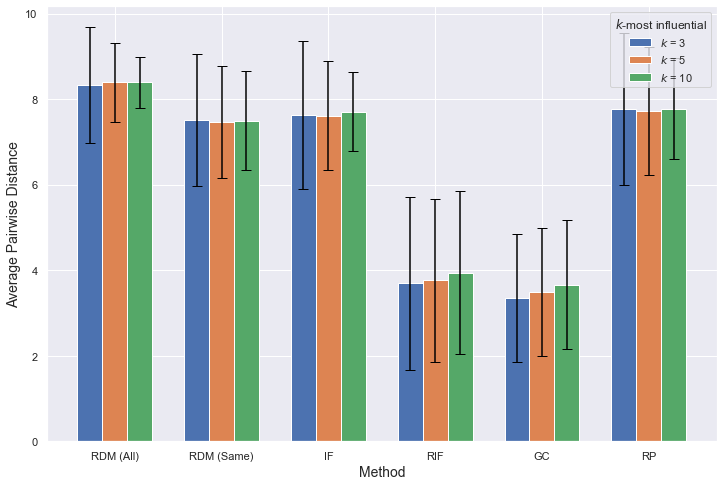

In [13]:
e.apd()

### DIVINE

In [16]:
def gamma_tradeoff():
    
    k = 5
    reshaped_train_x = train_x.reshape((num_train_points, -1))
    
    scores = [
        np.sum(inf, axis=1),
        np.sum(rif, axis=1),
        np.sum(gc, axis=1),
        np.sum(rp, axis=1),
        ds
    ]
    
    labels = [
        "IF",
        "RIF",
        "GC",
        "RP",
        "DS"
    ]
    
    gammas = np.append([0], np.logspace(-3, 9, num=50))    
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i in range(5):
        idxs = [select_top_diverse_k(scores[i], k, reshaped_train_x, gamma=g) for g in gammas]
        
        xs = [np.sum(pairwise_distances(reshaped_train_x[j])) / (k*(k-1)) for j in idxs]
        ys = [np.sum(scores[i][j]) for j in idxs]
        ys = ys / ys[0] # Normalise~
        
        ax.plot(xs, ys, label=labels[i], zorder=1)
        # ax.scatter(xs, ys, s=16, marker="x")
        
        # Maximum metric.
        ax.scatter(xs[0], ys[0], s=64, marker="D", color=hls[0], edgecolors="black", zorder=2)
        
        # Maximum product.        
        prod = np.argmax(xs * ys)
        ax.scatter(xs[prod], ys[prod], s=64, marker="D", color=hls[3], edgecolors="black", zorder=2)
        print("Optimal Gamma for {} = {:3e}".format(labels[i], gammas[prod]))
        
        # Maximum APD.
        max_apd = np.argmax(xs)
        ax.scatter(xs[max_apd], ys[max_apd], s=64, marker="D", color=hls[6], edgecolors="black", zorder=2)        
        
        
    ax.set_ylabel("Normalised Metric", fontdict={"fontsize": 14})
    ax.set_xlabel("Average Pairwise Distance", fontdict={"fontsize": 14})
    ax.legend(title="Method", loc="lower left")

Optimal Gamma for IF = 7.906043e+01
Optimal Gamma for RIF = 4.941713e-01
Optimal Gamma for GC = 1.456348e+01
Optimal Gamma for RP = 1.599859e-01
Optimal Gamma for DS = 0.000000e+00


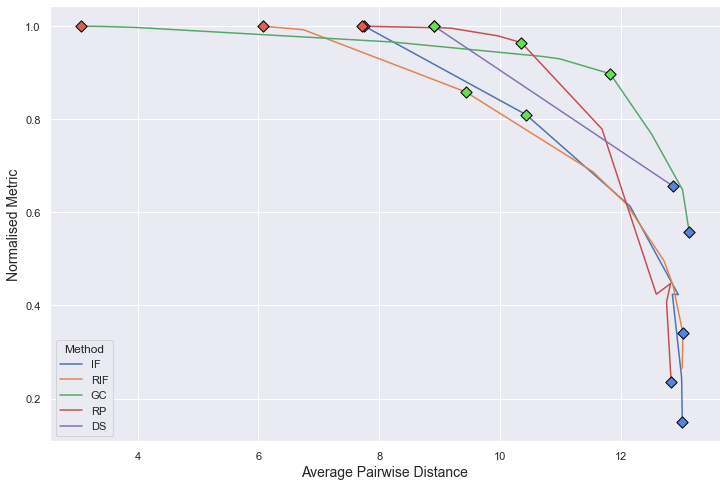

In [14]:
e.gamma_tradeoff()

In [18]:
def gamma_tradeoff_sr():
    
    k = 5
    reshaped_train_x = train_x.reshape((num_train_points, -1))
    kappa = np.sum(rbf_kernel(reshaped_train_x))
    
    scores = [
        np.sum(inf, axis=1),
        np.sum(rif, axis=1),
        np.sum(gc, axis=1),
        np.sum(rp, axis=1),
        ds
    ]
    
    labels = [
        "IF",
        "RIF",
        "GC",
        "RP",
        "DS"
    ]
    
    gammas = np.append([0], np.logspace(-3, 9, num=10))    
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i in range(5):
        idxs = [select_top_sum_redun_k(scores[i], k, reshaped_train_x, gamma=g) for g in gammas]
        
        xs = [kappa - np.sum(rbf_kernel(reshaped_train_x[j])) for j in idxs]
        ys = [np.sum(scores[i][j]) for j in idxs]
        ys = ys / ys[0] # Normalise~
        
        ax.plot(xs, ys, label=labels[i], zorder=1)
        # ax.scatter(xs, ys, s=16, marker="x")
        
        # Maximum metric.
        ax.scatter(xs[0], ys[0], s=64, marker="D", color=hls[0], edgecolors="black", zorder=2)
        
        # Maximum product.
        prod = np.argmax(xs * ys)
        ax.scatter(xs[prod], ys[prod], s=64, marker="D", color=hls[3], edgecolors="black", zorder=2)
        
        # Maximum APD.
        max_apd = np.argmax([np.sum(pairwise_distances(reshaped_train_x[j])) for j in idxs])
        ax.scatter(xs[max_apd], ys[max_apd], s=64, marker="D", color=hls[6], edgecolors="black", zorder=2)        
        
        
    ax.set_ylabel("Normalised Metric", fontdict={"fontsize": 14})
    ax.set_xlabel("Sum Redundancy", fontdict={"fontsize": 14})
    ax.legend(title="Method", loc="lower left")

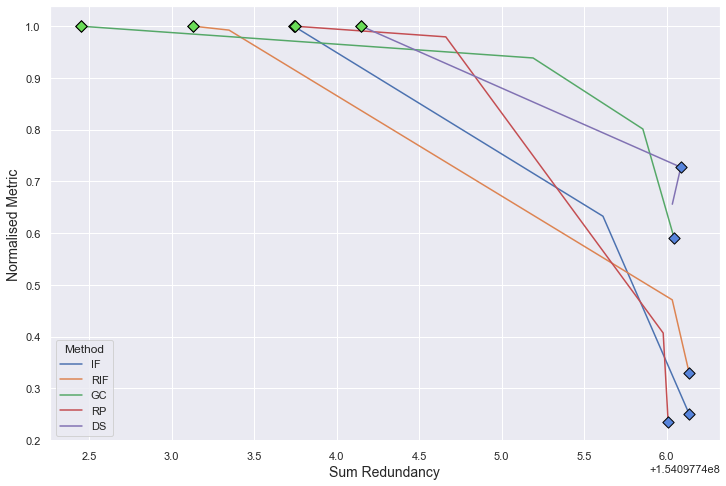

In [15]:
e.gamma_tradeoff_sr()

In [20]:
def gamma_tradeoff_local(test_idx):
    
    k = 5
    reshaped_train_x = train_x.reshape((num_train_points, -1))
    
    scores = [
        inf[:, test_idx],
        rif[:, test_idx],
        gc[:, test_idx],
        rp[:, test_idx]
    ]
    
    labels = [
        "IF",
        "RIF",
        "GC",
        "RP"
    ]
    
    gammas = np.append([0], np.logspace(-6, 6, num=50))    
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i in range(4):
        idxs = [select_top_diverse_k(scores[i], k, reshaped_train_x, gamma=g) for g in gammas]
        
        xs = [np.sum(pairwise_distances(reshaped_train_x[j])) / (k*(k-1)) for j in idxs]
        ys = [np.sum(scores[i][j]) for j in idxs]
        ys = ys / ys[0] # Normalise~
        
        ax.plot(xs, ys, label=labels[i], zorder=1)
        # ax.scatter(xs, ys, s=16, marker="x")
        
        # Maximum metric.
        ax.scatter(xs[0], ys[0], s=64, marker="D", color=hls[0], edgecolors="black", zorder=2)
        
        # Maximum product.
        prod = np.argmax(xs * ys)
        ax.scatter(xs[prod], ys[prod], s=64, marker="D", color=hls[3], edgecolors="black", zorder=2)
        print("Optimal Gamma for {} = {:3e}".format(labels[i], gammas[prod]))
        
        # Maximum APD.
        max_apd = np.argmax(xs)
        ax.scatter(xs[max_apd], ys[max_apd], s=64, marker="D", color=hls[6], edgecolors="black", zorder=2)        
        
        
    ax.set_ylabel("Normalised Metric", fontdict={"fontsize": 14})
    ax.set_xlabel("Average Pairwise Distance", fontdict={"fontsize": 14})
    ax.legend(title="Method", loc="lower left")

Optimal Gamma for IF = 2.559548e-02
Optimal Gamma for RIF = 8.685114e-04
Optimal Gamma for GC = 4.498433e-02
Optimal Gamma for RP = 4.714866e-03


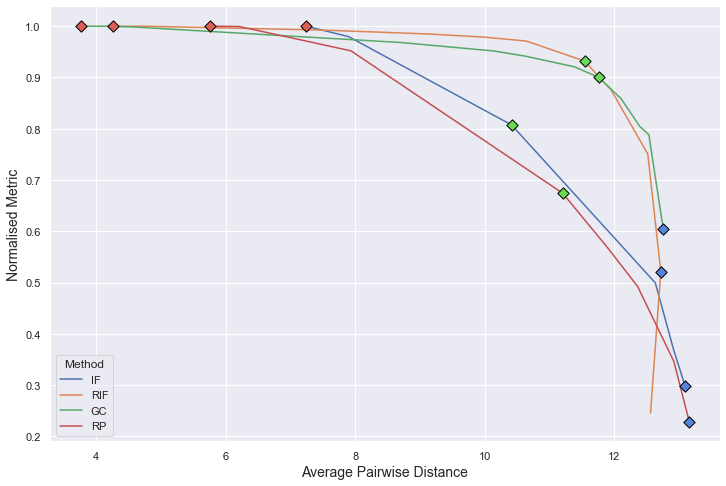

In [16]:
e.gamma_tradeoff_local(test_idx=0)

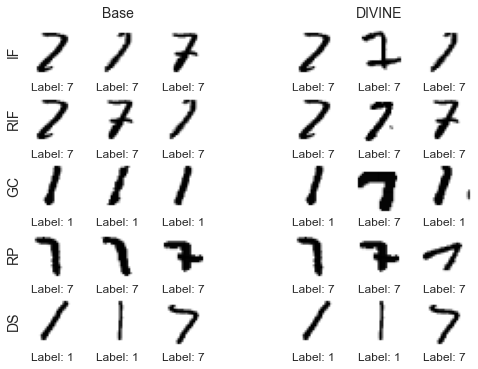

In [12]:
# Optimal Gamma for IF = 7.906043e+01
# Optimal Gamma for RIF = 4.941713e-01
# Optimal Gamma for GC = 1.456348e+01
# Optimal Gamma for RP = 1.599859e-01
# Optimal Gamma for DS = 0.000000e+00

e.divine_global(gammas={"inf": 7.9e01, "rif": 4.9e-01, "gc": 1.5e01, "rp": 1.6e-01, "ds": 0})

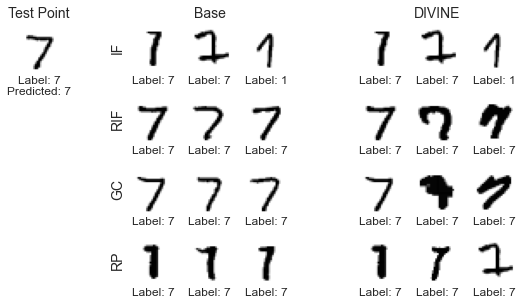

In [18]:
# test_idx = 0:
# Optimal Gamma for IF = 2.559548e-02
# Optimal Gamma for RIF = 8.685114e-04
# Optimal Gamma for GC = 4.498433e-02
# Optimal Gamma for RP = 4.714866e-03

e.divine_local(test_idx=0, gammas={"inf": 2.6e-02, "rif": 8.7e-04, "gc": 4.5e-02, "rp": 4.7e-03})

## Comparing Relevance

### Number of Unique Examples

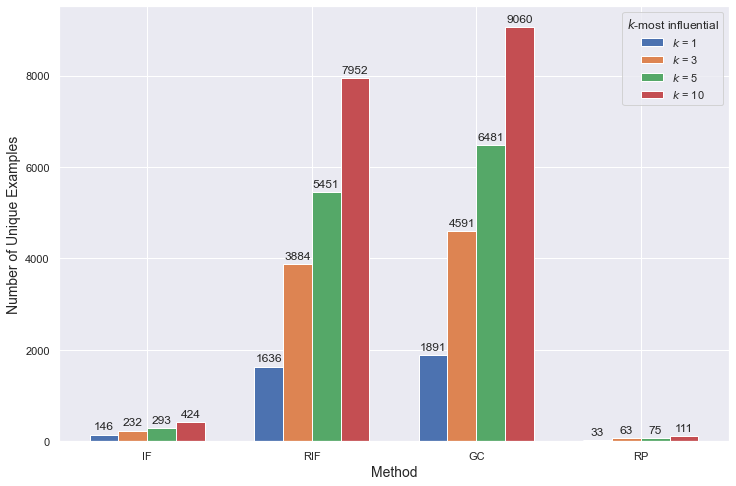

In [19]:
e.unique_examples()

### Identical Class Test

k = 1:
 IF: 0.911 ± 0.284
RIF: 0.986 ± 0.117
 GC: 0.987 ± 0.115
 RP: 0.987 ± 0.115
k = 3:
 IF: 0.864 ± 0.343
RIF: 0.986 ± 0.118
 GC: 0.987 ± 0.115
 RP: 0.987 ± 0.115
k = 5:
 IF: 0.844 ± 0.363
RIF: 0.985 ± 0.120
 GC: 0.987 ± 0.115
 RP: 0.987 ± 0.115
k = 10:
 IF: 0.817 ± 0.387
RIF: 0.984 ± 0.125
 GC: 0.987 ± 0.115
 RP: 0.987 ± 0.115


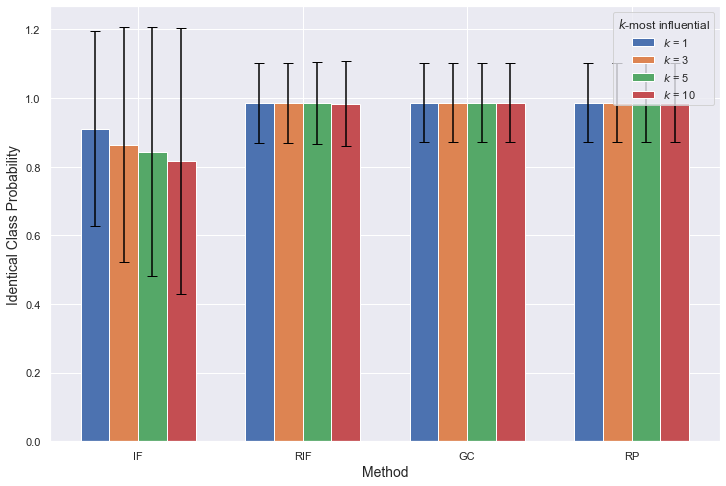

In [20]:
e.id_class_test()